# **Load Dataset**

In [ ]:
# !pip install opendatasets

In [ ]:
# import opendatasets as od
# url = "https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/data"
# od.download(url)

**Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide**

**Invasive means the cancer has spread into surrounding breast tissues. Ductal means the cancer started in the milk ducts, the tubes that carry milk from the lobules to the nipple. Carcinoma refers to any cancer that begins in the skin or other tissues that cover the lining of internal organs, such as breast tissue.**

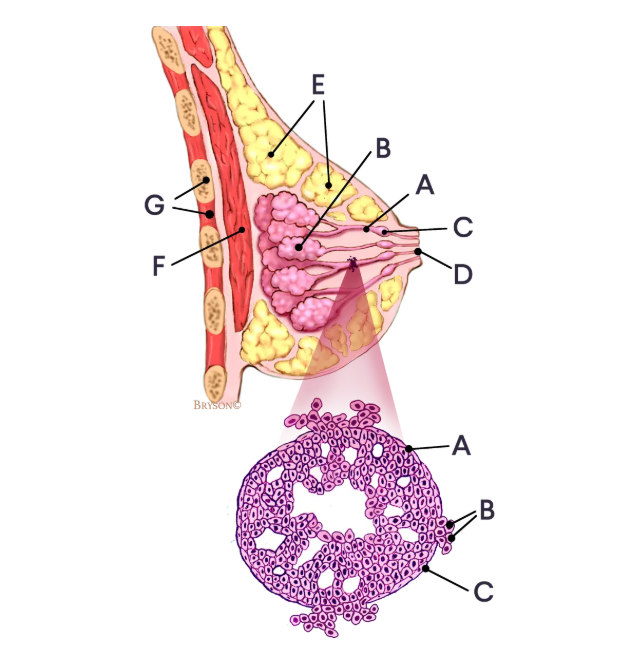

Normal breast with invasive ductal carcinoma (IDC) in an enlarged cross-section of the duct

- Breast profile: A Ducts B Lobules C Dilated section of duct to hold milk D Nipple E Fat F Pectoralis major muscle G Chest wall/rib cage

- Enlargement: A Normal duct cell B Ductal cancer cells breaking through the basement membrane C Basement membrane

**Inasive ductal carcinoma (IDC) is - with ~ 80 % of cases - one of the most common types of breast cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of breast cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefor deep learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available .**

**Importing Necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
import glob
import random
import os
from sklearn.metrics import classification_report , accuracy_score , precision_score , f1_score
import tensorflow as tf
import keras.utils as image

In [ ]:
dir = "/kaggle/input/breast-histopathology-images"
dataset = os.listdir(dir)
dataset[:10]

['10295',
 '10304',
 '12868',
 '10274',
 '12818',
 '14190',
 '12869',
 '9323',
 '10291',
 '12906']

In [ ]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

# for imgname in breast_img[:3]:
#     print(imgname)

# **Preprocessing**

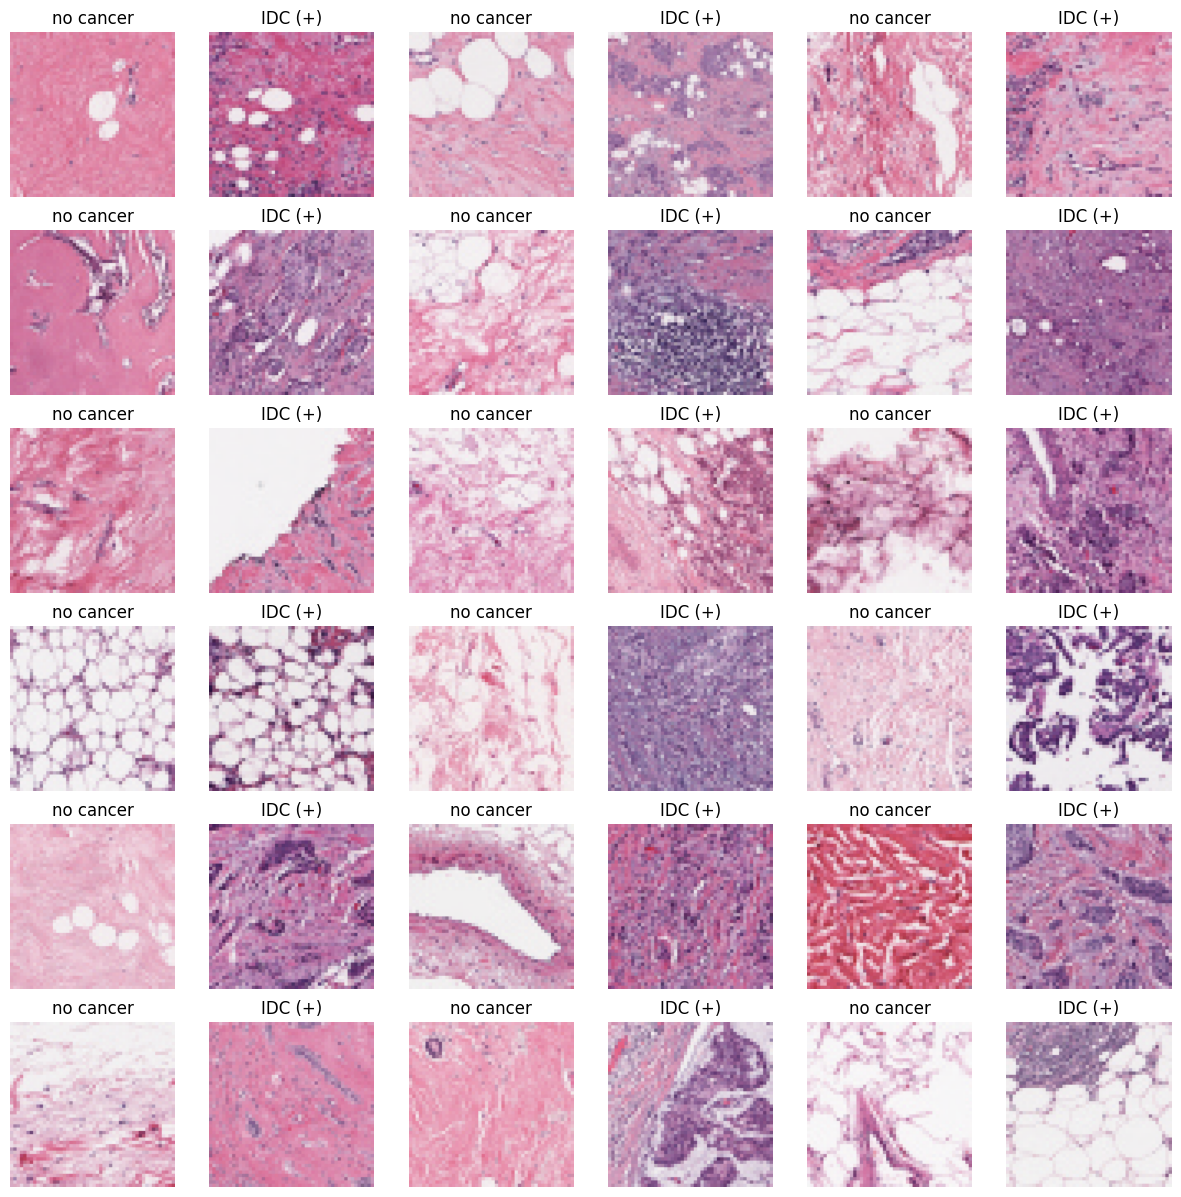

In [ ]:
# Non_IDC
N_IDC = []
# Positive_IDC
P_IDC = []

for img in breast_img:
  if img[-5] == "0":
    N_IDC.append(img)

  elif img[-5] == "1":
    P_IDC.append(img)


plt.figure(figsize = (15 , 15))

some_non = np.random.randint(0 , len(N_IDC) , 18)
some_can = np.random.randint(0 , len(P_IDC) , 18)

s = 0

for num in some_non:

  img = image.load_img((N_IDC[num]) , target_size = (100 , 100))
  img = image.img_to_array(img)

  plt.subplot(6,6 , 2*s+1)
  plt.axis("off")
  plt.title('no cancer')
  plt.imshow(img.astype('uint8'))

  s+=1

s = 1
for num in some_can:

  img = image.load_img((P_IDC[num]) ,  target_size= (100 , 100))
  img = image.img_to_array(img)

  plt.subplot(6,6 , 2*s)
  plt.axis("off")
  plt.title('IDC (+)')
  plt.imshow(img.astype('uint8'))
  s+=1

- Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels.

- Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?

- Though some of the healthy patches are very violet colored too!
Would be very interesting to hear what criteria are important for a pathologist.
I assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through.

In [ ]:
print(len(N_IDC))
print(len(P_IDC))

198738
78786


In [ ]:
NewN_IDC = N_IDC[:78786]

In [ ]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:

  n_img = cv2.imread(img , cv2.IMREAD_COLOR)
  n_img_size = cv2.resize(n_img , (50 , 50) , interpolation=cv2.INTER_LINEAR)
  non_img_arr.append([n_img_size , 0])


for img in P_IDC:
  c_img = cv2.imread(img , cv2.IMREAD_COLOR)
  c_img_size = cv2.resize(c_img , (50 , 50) , interpolation=cv2.INTER_LINEAR)
  can_img_arr.append([c_img_size , 1])

In [ ]:
print(f"Non IDC image array -  {len(non_img_arr)}")
print(f"Positive IDC image array -  {len(can_img_arr)}")
print(len(non_img_arr) + len(can_img_arr))

Non IDC image array -  78786
Positive IDC image array -  78786
157572


In [ ]:
import cv2
import numpy as np
import random

# Initialize data holders
non_img_arr = []
can_img_arr = []

# Read, resize and label the images
for img in NewN_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_resized = cv2.resize(n_img, (50, 50))
    non_img_arr.append((n_img_resized, 0))

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_resized = cv2.resize(c_img, (50, 50))
    can_img_arr.append((c_img_resized, 1))



In [ ]:
num_samples = min(len(non_img_arr), len(can_img_arr))
breast_img_arr = non_img_arr[:num_samples] + can_img_arr[:num_samples]


random.shuffle(breast_img_arr)

# Separate features and labels
X = np.array([item[0] for item in breast_img_arr], dtype=np.float32)
y = np.array([item[1] for item in breast_img_arr], dtype=np.uint8)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (157572, 50, 50, 3)
y shape: (157572,)


In [ ]:
def describedata(a , b):
  print("Total Number od images: {}".format(len(a)))
  print("Number of IDC(-) Images: {}".format(np.sum(b == 0)))
  print("Number of IDC(+) Images: {}".format(np.sum(b == 1)))

  print("Image shape (width , Height , Channels): {}".format(a[0].shape))

In [ ]:
describedata(X , y)

Total Number od images: 157572
Number of IDC(-) Images: 78786
Number of IDC(+) Images: 78786
Image shape (width , Height , Channels): (50, 50, 3)


In [ ]:
base_dir = "/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = os.listdir(base_dir)
len(folder)

279

Almost 280 patients. That's a small number compared to the expected number of patients one would like to analyse with our algorithm after deployment. Consequently overfitting to this specific patient distribution is very likely and we need to take care about the generalization performance of our model.

**How many patches do we have in total?**

Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm. How many of them do we have in total?

In [ ]:
total_images = 0
for n in  range(len(folder)):
  patient_id  = folder[n]
  for c in [0 , 1]:

    patient_path= base_dir + patient_id
    class_path = patient_path + "/" + str(c) + "/"
    subfile = os.listdir(class_path)
    total_images += len(subfile)

In [ ]:
total_images

277524

Ok, roughly 280000 images. To feed the algorithm with image patches it would be nice to store the path of each image. This way we can load batches of images only one by one without storing the pixel values of all images.

In [ ]:
from posix import listdir
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_dir + patient_id
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

data.head()

/tmp/ipykernel_35/2864425302.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.iloc[k]["path"] = class_path + image_path
/tmp/ipykernel_35/2864425302.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!


,patient_id,path,target
0,10295,/kaggle/input/breast-histopathology-images/IDC...,0
1,10295,/kaggle/input/breast-histopathology-images/IDC...,0
2,10295,/kaggle/input/breast-histopathology-images/IDC...,0
3,10295,/kaggle/input/breast-histopathology-images/IDC...,0
4,10295,/kaggle/input/breast-histopathology-images/IDC...,0


In [ ]:
data.shape

(277524, 3)

In [ ]:
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

In [ ]:
cancer_perc

target,0,1
patient_id,,
10253,0.872495,0.127505
10254,0.910377,0.089623
10255,0.665441,0.334559
10256,0.750000,0.250000
10257,0.672441,0.327559
...,...,...
9346,0.465834,0.534166
9347,0.875610,0.124390
9381,0.903469,0.096531


In [ ]:
# fig, ax = plt.subplots(1,3,figsize=(20,5))
# sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
# ax[0].set_xlabel("Number of patches")
# ax[0].set_ylabel("Frequency");
# ax[0].set_title("How many patches do we have per patient?");
# sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
# ax[1].set_title("How much percentage of an image is covered by IDC?")
# ax[1].set_ylabel("Frequency")
# ax[1].set_xlabel("% of patches with IDC");
# sns.countplot(data.target, palette="Set2", ax=ax[2]);
# ax[2].set_xlabel("no(0) versus yes(1)")
# ax[2].set_title("How many patches show IDC?");

# **Train and Test Split**

**Since we know about our datasets now next step is split data into train and test part. Here i am using 70 % and 30%  rule where 70% will be the train data and 30% will be test data**

In [ ]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.3)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train , num_classes = 2)
y_test = to_categorical(y_test , num_classes = 2)

print("Training Data Shape :" , x_train.shape)
print("Testing Data Shape :" , x_test.shape)

Training Data Shape : (110300, 50, 50, 3)
Testing Data Shape : (47272, 50, 50, 3)


# **Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import itertools

In [ ]:
early_stop = EarlyStopping(monitor = "val_loss" , patience = 5)

model = Sequential()

# Input size - (50 x 50)
model.add(Conv2D(32 , (3,3) , activation = "relu" , padding  = "same" , input_shape = (50 , 50 , 3)))
# output size - (50 x 50)
model.add(BatchNormalization())

# input size - (50 x 50)
model.add(Conv2D(32 , (3,3) , activation = "relu" , padding = "same"))
# output size - (50 x 50)
model.add(MaxPooling2D(2,2))
# output size - (25 x 25)
model.add(BatchNormalization())
# output size - (25 x 25)
model.add(Dropout(0.3))

# input size - (25 x 25)
model.add(Conv2D(64 , (3,3) , activation = "relu" , padding = "same"))
# output size - (25 x 25)
model.add(BatchNormalization())

# input size - (25 x 25)
model.add(Conv2D(64 , (3,3) , activation = "relu", padding = "same"))
# output size - (25 x 25)
model.add(BatchNormalization())
# output size - (25 x 25)
model.add(MaxPooling2D(2,2))
# output size - (12 x 12)
model.add(Dropout(0.3))

# input size - (12 x 12)
model.add(Conv2D(128 , (3,3) , activation = "relu", padding = "same"))
# output size - (12 x 12)

model.add(Flatten())
model.add(Dense(128 , activation = "relu" ,))
model.add(BatchNormalization())

model.add(Dense(64 , activation = "relu"))
model.add(BatchNormalization())

model.add(Dense(64 , activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(24 , activation = "relu"))

model.add(Dense(2 , activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751522388.020844      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,514,410 (9.59 MB)

 Trainable params: 2,513,642 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
model.compile(optimizer = "adam" , loss = "binary_crossentropy" , metrics = ["accuracy"])

In [ ]:
history = model.fit(
    x_train ,
    y_train ,
    validation_data = (x_test , y_test) ,
    epochs = 10 ,
    batch_size = 35
)

Epoch 1/10


I0000 00:00:1751522422.330808     105 service.cc:148] XLA service 0x7c02a00027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751522422.331282     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751522423.083239     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  22/3152 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6666 - loss: 0.6289   

I0000 00:00:1751522428.240326     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3152/3152 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.8151 - loss: 0.4253 - val_accuracy: 0.8316 - val_loss: 0.3845
Epoch 2/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8432 - loss: 0.3644 - val_accuracy: 0.7952 - val_loss: 0.4740
Epoch 3/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8549 - loss: 0.3434 - val_accuracy: 0.7179 - val_loss: 0.6511
Epoch 4/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8463 - loss: 0.3602 - val_accuracy: 0.8535 - val_loss: 0.3551
Epoch 5/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8546 - loss: 0.3422 - val_accuracy: 0.8017 - val_loss: 0.4534
Epoch 6/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8575 - loss: 0.3388 - val_accuracy: 0.8222 - val_loss: 1.6738
Epoch 7/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8618 - loss: 0.3295 - val_accuracy: 0.8343 - val_loss: 0.9783
Epoch 8/10
3152/3152 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8722 - loss: 0.3078 - va

**we trained our model , Now next step is to chack accuracy of train data and test data**

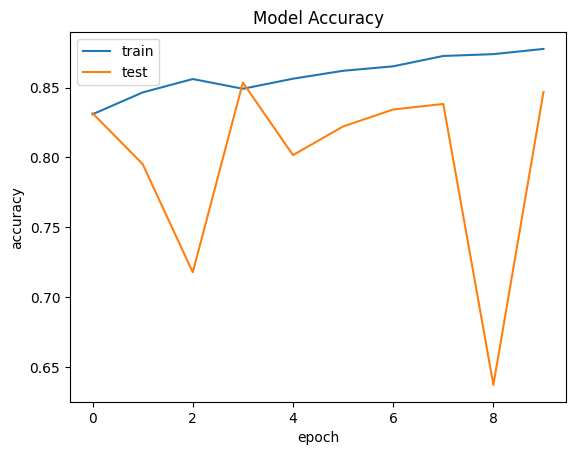

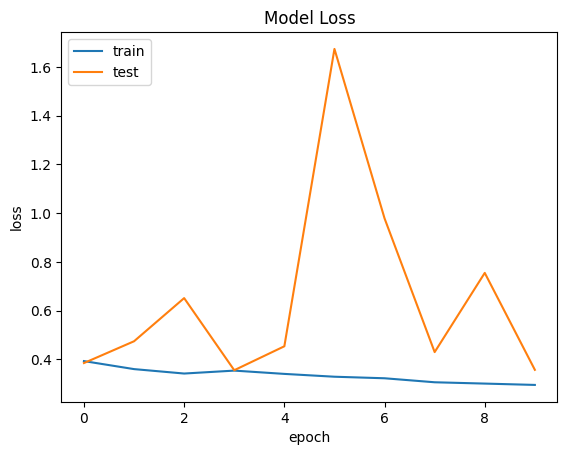

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Accuracy of our model on train and test data is increasing . But Slightly facing an overfitting problem.
- Loss of train and test is decreasing  with epochs , But at one pint train and test loss is increase , But if we increase more epochs value then it can possible loss will decrease

1478/1478 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


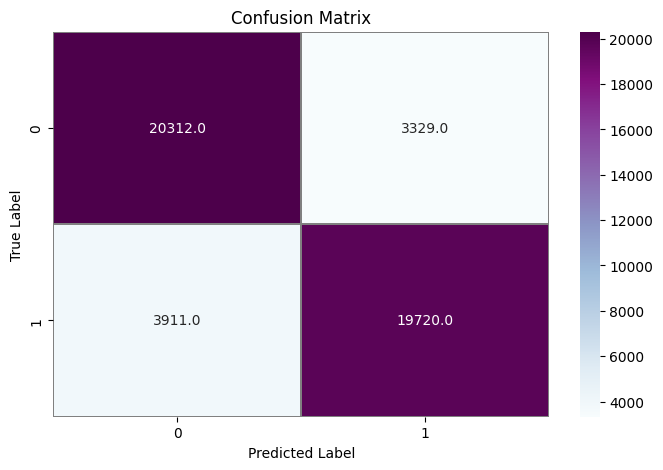

In [ ]:
from sklearn.metrics import accuracy_score , confusion_matrix
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

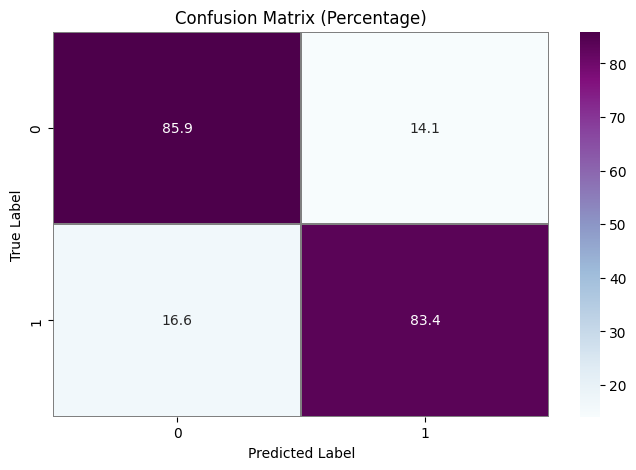

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

Insight -

- 85% our model predict it's 0 and as per our data it is also 0 label
- 83% our model predict it's 1 and as per our data it is also 1 label
- 16% model predict patient doen't have a cancer but as per data patient has
- 14% model predict patient has a cancer but as per data it is not

In [ ]:
model.evaluate(x_test,y_test)

1478/1478 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8495 - loss: 0.3519


[0.3567143380641937, 0.8468437790870667]

# **Testing the model**

**This is what crucial step , when we will going to be check how our model work on unseen data**

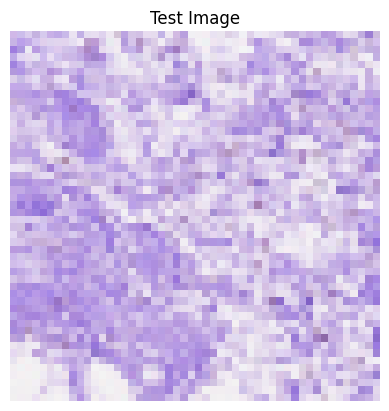

In [ ]:
import matplotlib.pyplot as plt
def  img_plot(x_test , index = 0):

    plt.imshow(x_test[index].astype('uint8'))  # force uint8 for proper display
    plt.axis('off')
    plt.title('Test Image')
    plt.show()


index  = 100
img_plot(x_test , index)


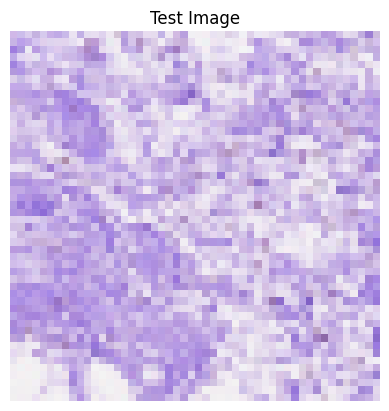

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted value  0
True value 0


In [ ]:
index  = 100
img_plot(x_test , index)
input = x_test[index:index+1]
preds = model.predict(input)[0].argmax()
label = y_test[index].argmax()
print("Predicted value " , preds)
print("True value" , label)

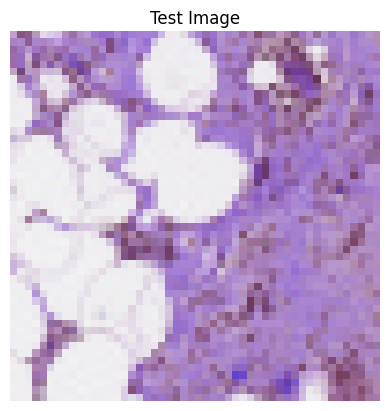

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted value  1
True value 1


In [ ]:
index  = 4000
img_plot(x_test , index)
input = x_test[index:index+1]
preds = model.predict(input)[0].argmax()
label = y_test[index].argmax()
print("Predicted value " , preds)
print("True value" , label)